# QG 中期考核

## 相关设置

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# sklearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 一个cell显示多输出

pd.set_option('display.max_rows', 100)  # 设置最大显示100行
pd.set_option('display.max_columns', 100)  # 设置最大显示100列

import warnings
warnings.filterwarnings("ignore")

## 查看数据

In [3]:
train_df = pd.read_csv('./data//train/train.csv')
test_df = pd.read_csv('./data/test/test2.csv')

In [4]:
train_df.head()

,id_num,program_type,program_id,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y,Y_1,136.0,150.0,offline,intermediate,9389.0,M,Matriculation,3.0,24.0,5.0,N,1.0,0
1,16523_44,T,T_1,131.0,44.0,offline,easy,16523.0,F,High School Diploma,4.0,26.0,2.0,N,3.0,1
2,13987_178,Z,Z_2,120.0,178.0,online,easy,13987.0,M,Matriculation,1.0,40.0,1.0,N,2.0,1
3,13158_32,T,T_2,117.0,32.0,offline,easy,13158.0,F,Matriculation,3.0,NaN,4.0,N,1.0,1
4,10591_84,V,V_3,131.0,84.0,offline,intermediate,10591.0,F,High School Diploma,1.0,42.0,2.0,N,4.0,1


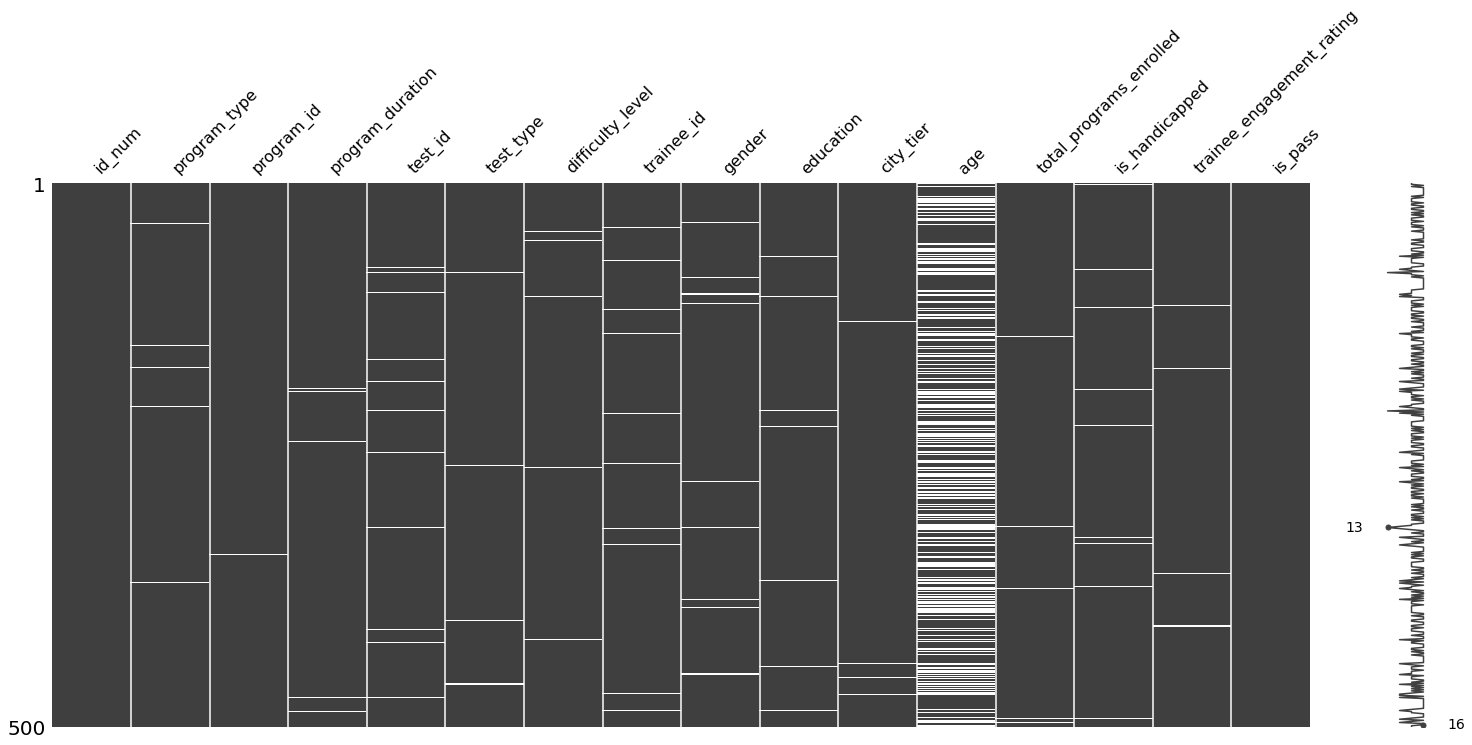

In [5]:
msno.matrix(train_df.sample(500))#可视化缺失值

我们通过可视化缺失值，发现我们有age缺失很多，我们需要通过相关方法来处理age

In [6]:
for col in train_df.columns:
    pct_missing = np.mean(train_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id_num - 0.0%
program_type - 1.0%
program_id - 1.0%
program_duration - 1.0%
test_id - 1.0%
test_type - 1.0%
difficulty_level - 1.0%
trainee_id - 1.0%
gender - 1.0%
education - 1.0%
city_tier - 1.0%
age - 39.0%
total_programs_enrolled - 1.0%
is_handicapped - 1.0%
trainee_engagement_rating - 2.0%
is_pass - 0.0%


age缺失了39%

## 数据可视化

### 处理方法一：拟合age

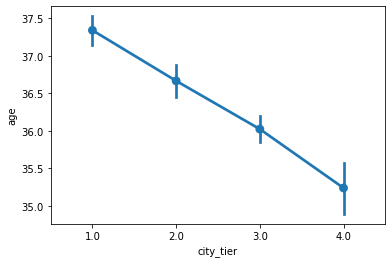

In [56]:
age1=sns.pointplot(y="age", x="city_tier", data=train_df)

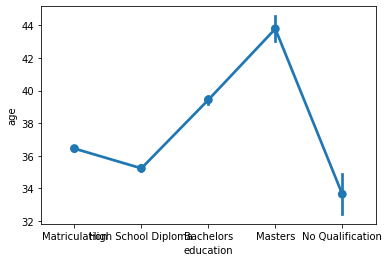

In [57]:
age1=sns.pointplot(y="age", x="education", data=train_df)

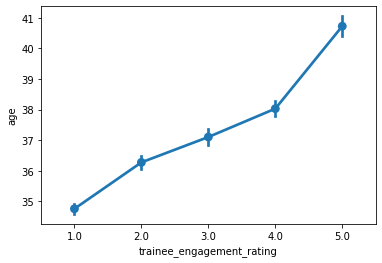

In [8]:
age1=sns.pointplot(y="age", x="trainee_engagement_rating", data=train_df)

我们观察到，age与上诉关系具有很明显的联系，我们可以借助以上条件来建模拟合年龄

#### version1:education,city_tier,trainee_engagement_rating来拟合

In [7]:
education= pd.get_dummies(train_df["education"])
predict_feature=["city_tier","trainee_engagement_rating"]
predict_feature=train_df[predict_feature]

predict_feature=predict_feature.join(education)

In [8]:
age=train_df['age']
predict_feature=predict_feature.join(age)

In [9]:
from sklearn.impute import KNNImputer
predict_feature_copy= predict_feature.copy(deep=True)
null_index = predict_feature_copy.loc[predict_feature_copy['age'].isnull(), :].index

imputer = KNNImputer(n_neighbors=10)
predict_feature_copy[['age','city_tier','trainee_engagement_rating','Bachelors','High School Diploma','Masters','Matriculation']] = imputer.fit_transform(predict_feature_copy[['age','city_tier','trainee_engagement_rating','Bachelors','High School Diploma','Masters','Matriculation']])
train_df['age']=predict_feature_copy['age']

In [10]:
train_df.head()

,id_num,program_type,program_id,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y,Y_1,136.0,150.0,offline,intermediate,9389.0,M,Matriculation,3.0,24.0,5.0,N,1.0,0
1,16523_44,T,T_1,131.0,44.0,offline,easy,16523.0,F,High School Diploma,4.0,26.0,2.0,N,3.0,1
2,13987_178,Z,Z_2,120.0,178.0,online,easy,13987.0,M,Matriculation,1.0,40.0,1.0,N,2.0,1
3,13158_32,T,T_2,117.0,32.0,offline,easy,13158.0,F,Matriculation,3.0,35.0,4.0,N,1.0,1
4,10591_84,V,V_3,131.0,84.0,offline,intermediate,10591.0,F,High School Diploma,1.0,42.0,2.0,N,4.0,1


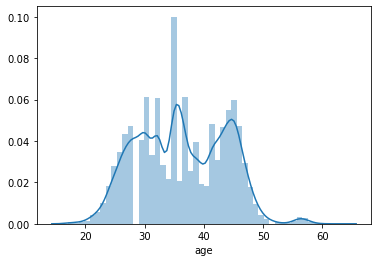

In [11]:
sns.distplot(train_df['age'])

#### version2: 线性回归来拟合
借助education，通过线性回归来拟合age

In [60]:
# # 建立线性回归来预测
# train_df.loc[train_df['education'] == 'No Qualification', "education"] = 0
# train_df.loc[train_df['education']  == 'High School Diploma', "education"] = 1
# train_df.loc[train_df['education'] == 'Matriculation', "education"] = 2
# train_df.loc[train_df['education'] == 'Bachelors', "education"] = 3
# train_df.loc[train_df['education'] == 'Masters', "education"] = 4
# train_df=train_df[pd.notnull(train_df['education'])]
# train_df_copy=train_df.copy()
# train_df_copy=train_df_copy[pd.notnull(train_df_copy['age'])]

# linear=LinearRegression()
# education=train_df_copy['education']
# age=train_df_copy['age']
# education=education.values.reshape(-1,1)
# age=age.values.reshape(-1,1)
# linear.fit(education,age)

LinearRegression()

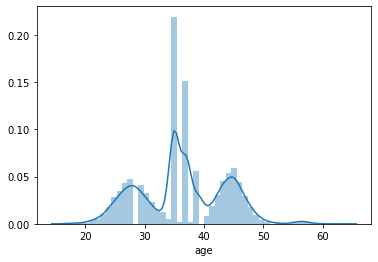

In [62]:
# # 建好模型后我们开始拟合
# education=train_df['education']
# education=education.values.reshape(-1,1)
# y_pre=linear.predict(education)
# y_pre=pd.DataFrame(y_pre)
# train_df.reset_index(inplace=True,drop=True)
# age=train_df['age']
# age=pd.DataFrame(age)
# age=age.join(y_pre)
# age.loc[age['age'].isnull(),'age']=age.loc[age['age'].isnull(),0]
# age=age.drop([0],axis=1)
# train_df['age']=age['age']

# sns.distplot(train_df['age'])

#### version3 GBDT 梯度提升树来拟合age

In [14]:
train_df.loc[train_df['education'] == 'No Qualification', "education"] = 0
train_df.loc[train_df['education']  == 'High School Diploma', "education"] = 1
train_df.loc[train_df['education'] == 'Matriculation', "education"] = 2
train_df.loc[train_df['education'] == 'Bachelors', "education"] = 3
train_df.loc[train_df['education'] == 'Masters', "education"] = 4

train_df=train_df[pd.notnull(train_df['education'])]

train_df_copy=train_df.copy()
train_df_copy=train_df_copy[pd.notnull(train_df_copy['age'])]
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
education=train_df_copy['education']
age=train_df_copy['age']
education=education.values.reshape(-1,1)
age=age.values.reshape(-1,1)
gbc.fit(education,age)

GradientBoostingClassifier()

In [16]:
education=train_df['education']
education=education.values.reshape(-1,1)
y_pre=gbc.predict(education)
y_pre=pd.DataFrame(y_pre)

# 重置index下标，否则下面不能够正确的合并
train_df.reset_index(inplace=True,drop=True)

age=train_df['age']
age=pd.DataFrame(age)
age=age.join(y_pre)
age.loc[age['age'].isnull(),'age']=age.loc[age['age'].isnull(),0]
age=age.drop([0],axis=1)
train_df['age']=age['age']

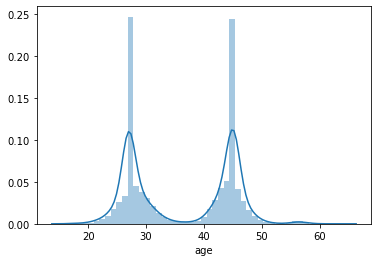

In [18]:
# sns.distplot(train_df['age'])

#### version4 联合测试集的age进行随机拟合

In [6]:
data=[train_df,test_df]

for dataset in data:
    mean = train_df["age"].mean()
    std = test_df["age"].std()
    is_null = dataset["age"].isnull().sum()
    # 计算均值、std和is_null之间的随机数
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # 用随机生成的值填充年龄栏中的NaN值
    age_slice = dataset["age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["age"] = age_slice
    dataset["age"] = train_df["age"].astype(int)

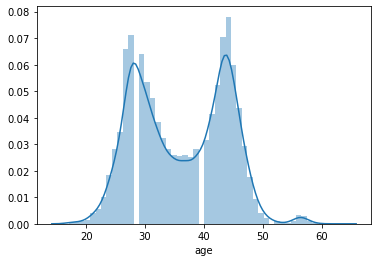

In [7]:
sns.distplot(train_df['age'])

最后一种就是直接删除age，丢失的数据有39%。经过我的多次选择，我最后选择用version1，为什么呢，因为训练出来我们的准确率最高。

## 特征工程

In [23]:
train_df.head()

,id_num,program_type,program_id,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y,Y_1,136.0,150.0,offline,intermediate,9389.0,M,Matriculation,3.0,24.0,5.0,N,1.0,0
1,16523_44,T,T_1,131.0,44.0,offline,easy,16523.0,F,High School Diploma,4.0,26.0,2.0,N,3.0,1
2,13987_178,Z,Z_2,120.0,178.0,online,easy,13987.0,M,Matriculation,1.0,40.0,1.0,N,2.0,1
3,13158_32,T,T_2,117.0,32.0,offline,easy,13158.0,F,Matriculation,3.0,35.0,4.0,N,1.0,1
4,10591_84,V,V_3,131.0,84.0,offline,intermediate,10591.0,F,High School Diploma,1.0,42.0,2.0,N,4.0,1


In [12]:
# 计算相关性
train_df_corr=train_df.copy()
train_df_corr['program_type']=train_df_corr['program_type'].astype('category').cat.codes
train_df_corr['program_duration']=train_df_corr['program_duration'].astype('category').cat.codes
train_df_corr['difficulty_level']=train_df_corr['difficulty_level'].astype('category').cat.codes
train_df_corr['is_handicapped']=train_df_corr['is_handicapped'].astype('category').cat.codes
train_df_corr['test_type']=train_df_corr['test_type'].astype('category').cat.codes
train_df_corr['gender']=train_df_corr['gender'].astype('category').cat.codes
train_corr=train_df_corr.corr()

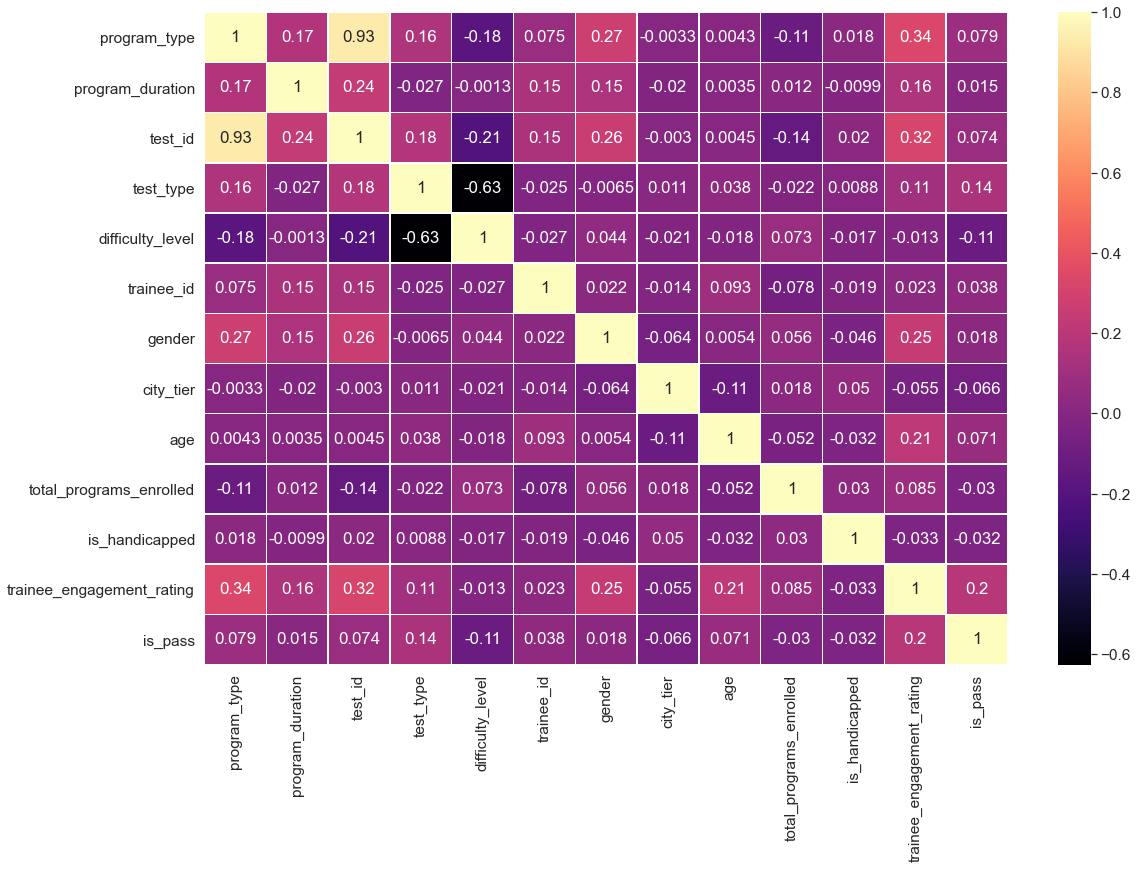

In [16]:
plt.figure(figsize=(18, 12))
sns.set(font_scale=1.4)
sns.heatmap(train_corr, 
            annot=True, 
            linecolor='white', 
            linewidth=0.5, 
            cmap='magma');

In [ ]:
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数




from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
x, Y = train_df,y

RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(data,y)
# 采用逻辑回归
ref2 = RFE(estimator=LogisticRegression(), n_features_to_select=2).fit(data,y)
print (ref2.ranking_)

# 返回结果
# [20 13  8 10  7 12 15  2 16  6 11  3 14 18  1  5  4 19  9 17  1]
# 特征的重要性 例如最后一个特征最重要

In [25]:
train_df.head()

,id_num,program_type,program_id,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y,Y_1,136.0,150.0,offline,intermediate,9389.0,M,Matriculation,3.0,24.0,5.0,N,1.0,0
1,16523_44,T,T_1,131.0,44.0,offline,easy,16523.0,F,High School Diploma,4.0,26.0,2.0,N,3.0,1
2,13987_178,Z,Z_2,120.0,178.0,online,easy,13987.0,M,Matriculation,1.0,40.0,1.0,N,2.0,1
3,13158_32,T,T_2,117.0,32.0,offline,easy,13158.0,F,Matriculation,3.0,35.0,4.0,N,1.0,1
4,10591_84,V,V_3,131.0,84.0,offline,intermediate,10591.0,F,High School Diploma,1.0,42.0,2.0,N,4.0,1


In [26]:
#独热处理
features=['program_type','test_type','difficulty_level','education','gender']
x = pd.get_dummies(train_df[features])
X=train_df[['age','test_id','trainee_engagement_rating','program_id','program_duration','trainee_id','city_tier','total_programs_enrolled']]
X=X.join(x)

In [27]:
X["program_id"] = pd.factorize(X["program_id"])[0].astype(np.uint16)

In [28]:
# 删除带NAN的数据行
y=train_df['is_pass']
X=X.join(y)
X=X.dropna(axis=0,how='any')
y=X['is_pass']
X=X.drop(['is_pass'],axis=1)

In [29]:
X

,age,test_id,trainee_engagement_rating,program_id,program_duration,trainee_id,city_tier,total_programs_enrolled,program_type_S,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_offline,test_type_online,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification,gender_F,gender_M
0,24.0,150.0,1.0,0,136.0,9389.0,3.0,5.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1
1,26.0,44.0,3.0,1,131.0,16523.0,4.0,2.0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2,40.0,178.0,2.0,2,120.0,13987.0,1.0,1.0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1
3,35.0,32.0,1.0,3,117.0,13158.0,3.0,4.0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0
4,42.0,84.0,4.0,4,131.0,10591.0,1.0,2.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49991,26.0,61.0,1.0,7,134.0,13936.0,4.0,3.0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1
49992,26.0,173.0,1.0,2,120.0,12375.0,4.0,1.0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0
49993,41.4,115.0,4.0,10,121.0,4379.0,2.0,5.0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
49995,41.0,42.0,1.0,3,117.0,18109.0,2.0,2.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0


## 模型训练

In [30]:
# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 逻辑回归模型

In [31]:
alg = LogisticRegression(random_state=1, solver='liblinear') # 初始化逻辑回归类
alg.fit(X_train,y_train)
cross_val_score(alg,X,y)

LogisticRegression(random_state=1, solver='liblinear')

array([0.71201047, 0.69695647, 0.71353769, 0.70968798, 0.70466943])

In [32]:
y_alg=alg.predict(X_test)
accuracy_score(y_test,y_alg)
# 无论交叉验证 accuracy_score 的默认参数 cv=5

0.7021926475400895

### 梯度上升树模型

In [33]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
cross_val_score(gbc,X,y)

GradientBoostingClassifier()

array([0.72488273, 0.72324643, 0.72390095, 0.73085315, 0.71994327])

In [34]:
y_gbc=gbc.predict(X_test)
accuracy_score(y_test,y_gbc)

0.7307734264208574

### 梯度下降法

In [35]:
sgd=SGDClassifier()
sgd.fit(X_train,y_train)

SGDClassifier()

In [36]:
cross_val_score(sgd,X,y)

array([0.30795244, 0.31886113, 0.6791753 , 0.69594152, 0.678813  ])

In [37]:
y_sgd=sgd.predict(X_test)
accuracy_score(y_test,y_sgd)

0.6581215228537144

### 随机森林

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [39]:
y_rfc=rfc.predict(X_test)
accuracy_score(y_test,y_rfc)

0.7360095996509218

In [40]:
cross_val_score(rfc,X,y)

array([0.73240973, 0.73306425, 0.72728264, 0.72899847, 0.72703469])

### 决策树

In [41]:
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)
cross_val_score(tree,X,y)

DecisionTreeClassifier()

array([0.67710265, 0.67448456, 0.67884804, 0.68219507, 0.68394065])

## 模型预测

In [43]:
from sklearn.impute import KNNImputer
predict_feature_copy= predict_feature.copy(deep=True)
null_index = predict_feature_copy.loc[predict_feature_copy['age'].isnull(), :].index

imputer = KNNImputer(n_neighbors=10)
predict_feature_copy[['age','city_tier','trainee_engagement_rating','Bachelors','High School Diploma','Masters','Matriculation']] = imputer.fit_transform(predict_feature_copy[['age','city_tier','trainee_engagement_rating','Bachelors','High School Diploma','Masters','Matriculation']])
test_df['age']=predict_feature_copy['age']

In [44]:
#独热处理
features=['program_type','test_type','difficulty_level','education','gender']
x = pd.get_dummies(test_df[features])
X=test_df[['age','test_id','trainee_engagement_rating','program_id','program_duration','trainee_id','city_tier','total_programs_enrolled']]
X=X.join(x)

In [45]:
X["program_id"] = pd.factorize(X["program_id"])[0].astype(np.uint16)

In [46]:
X=X.fillna(method='bfill')

In [47]:
y_pre=rfc.predict(X)

In [48]:
sub2=pd.read_csv('./data/submission/submission2.csv')
sub2['is_pass']=y_pre

In [50]:
sub2.to_csv("rfc1111.csv",index=False,sep=',')